Lets first load few libraries. lphys is where we define our utility functions.

In [11]:
import lphys
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import awkward as ak

We will load two files: one with data, the other with simulation. You can change the datafile to use the electrons dataset instead. You can also change the simulation for the CMS simulation.

Files are in the ROOT format, and can be opened with the uproot package. We then locate the tree with event data in the opened file.

In [2]:
# input files
data_file = "doubleMu2011_ntuple.root" # "doubleEl2011_Ntuple.root"
simu_file = "delpheAnalysisZ.root" # "ppNeutralCurrentFullsim_ntuple.root"

In [3]:
datafile = uproot.open(data_file)
simufile = uproot.open(simu_file)
datatree = datafile['LPHY2131analysis/WeakBosonsAnalysis']
simutree = simufile['LPHY2131analysis/WeakBosonsAnalysis']

The content of the tree can be checked with the command below. As you can see, we find back all the branches introduced during the first session, with the C++ type, and the python equivalent.
uproot will give us access to each branch through objects very similar to Numpy arrays (Akward arrays are basically non-rectangular Numpy arrays (we need that since the number of muons, electrons or jets varies from event to event.

In [4]:
simutree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuons               | int32_t                  | AsDtype('>i4')
MuonsPt              | double[]                 | AsJagged(AsDtype('>f8'))
MuonsEta             | double[]                 | AsJagged(AsDtype('>f8'))
MuonsPhi             | double[]                 | AsJagged(AsDtype('>f8'))
nElectrons           | int32_t                  | AsDtype('>i4')
ElectronsPt          | double[]                 | AsJagged(AsDtype('>f8'))
ElectronsEta         | double[]                 | AsJagged(AsDtype('>f8'))
ElectronsPhi         | double[]                 | AsJagged(AsDtype('>f8'))
invMass              | double                   | AsDtype('>f8')
transvMass           | double                   | AsDtype('>f8')
dileptonPt           | double                   | AsDtype('>f8')
dileptonEta          | double                   | AsDtype('>f8'

Our work will be to select event of interest. We will achieve that by modifying the function below.
Cuts can be applied in step, each new step operating on the output of the previous step.

In [5]:
# Here is an example to start with. Cuts should be tuned and complemented by others.

# cuts
def selection(events, branches=None):
    # first filter on the number of objects
    filter = (events.nMuons==2) & (events.nElectrons==0) & (events.nJets<10)
    selected = events[filter]
    # then apply a cut on the muon Pt
    filter = (selected.MuonsPt[:,0]>10) & (selected.MuonsPt[:,1]>2) 
    selected = selected[filter]
    # cut on the isolation
    filter = (selected.MuonIsolation[:,0]<0.5) & (selected.MuonIsolation[:,1]<0.5) 
    selected = selected[filter]
   
    if branches:
        return selected[branches]
    else:
        return selected

We then apply our selection on the trees.
The arguments of the analyzeTree method are the tree, the selection, and the list of branches that we want to keep.

In [6]:
selected_data = lphys.analyzeTree(datatree,["invMass"],selection=selection)
selected_simu = lphys.analyzeTree(simutree,["invMass"],selection=selection)

We can then draw the content using PyPlot, here for the simulation.

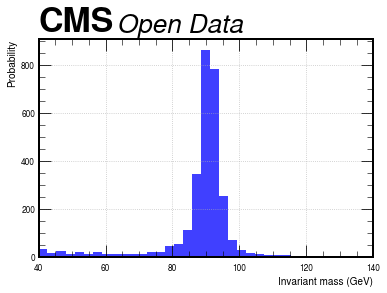

In [7]:
# keep that here.
hep.style.use(hep.style.CMS)
hep.cms.text("Open Data")
# the histogram of the data
n, bins, patches = plt.hist(selected_simu["invMass"], 100, density=False, facecolor='b', alpha=0.75)
plt.xlabel('Invariant mass (GeV)')
plt.ylabel('Probability')
plt.xlim(40, 140)
#plt.ylim(0, 0.3)
plt.grid(True)

The lphys package provides two utility functions to compare data and simulation.
- The sidePlot function will draw the histogram for the selected quantity for data and simulation side by side.
- The plot function will draw data superimposed to simulation.

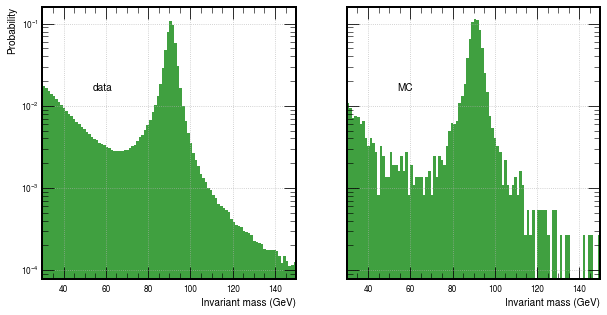

In [8]:
lphys.sidePlot(selected_data["invMass"], selected_simu["invMass"], 
               (30,150), 'Invariant mass (GeV)', ylabel='Probability', 
               nbins=100, islog=True, color='g', density=True)

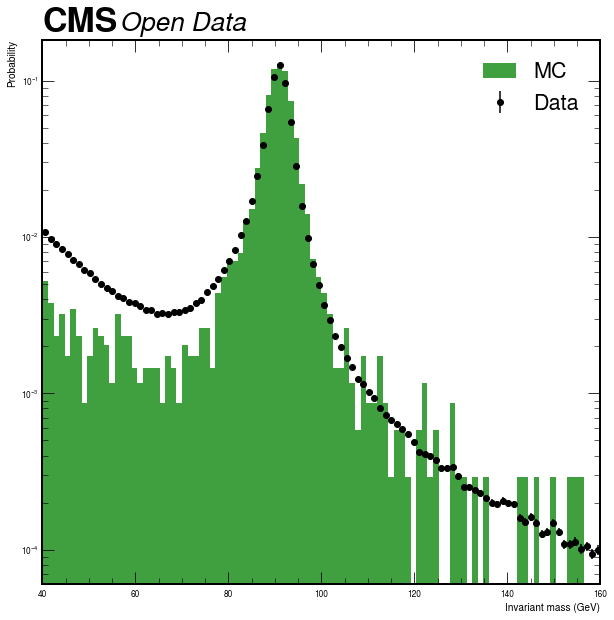

In [9]:
lphys.plot(selected_data["invMass"], selected_simu["invMass"], [],
           (40,160), 'Invariant mass (GeV)', ylabel='Probability', 
           nbins=100, islog=True, color='g', density=True)

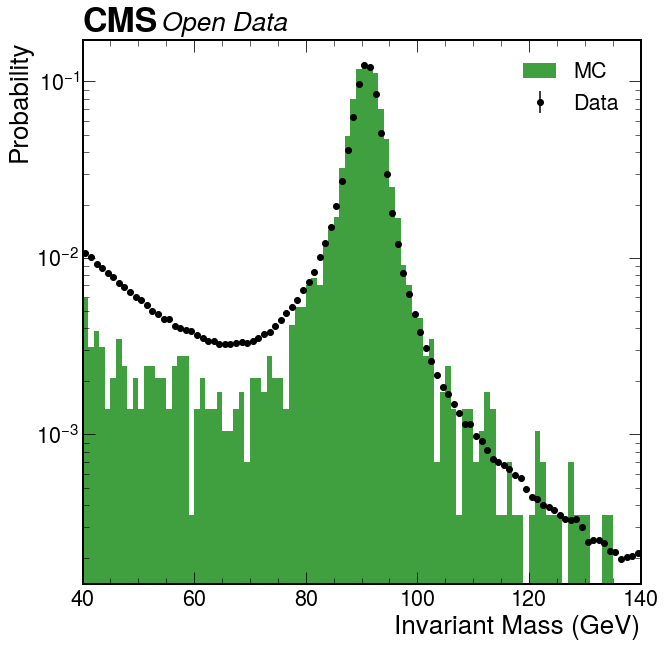

In [32]:
#same as above using Plotter instead.
myplot = lphys.Plotter(None, logscale=True, legend=True, xlabel="Invariant Mass (GeV)", ylabel="Probability")
myplot.setSimulation(selected_simu["invMass"])
myplot(data=np.histogram(ak.to_numpy(selected_data["invMass"]).astype('double'), bins=100, range=(40,140),density=True))